### Extrative text summarization using Graphical representation 

In [150]:
import numpy as np
import pandas as pd
import nltk
nltk.download('punkt')
import re
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Dataset
Scraped articles regarding Tennis matches




In [151]:
df = pd.read_excel("/content/tennis_articles.xlsx")
df.drop(["source"], axis=1, inplace=True)

In [152]:
df.head()

,article_id,article_title,article_text
0,1,"I do not have friends in tennis, says Maria Sh...",Maria Sharapova has basically no friends as te...
1,2,Federer defeats Medvedev to advance to 14th Sw...,"BASEL, Switzerland (AP) — Roger Federer advanc..."
2,3,Tennis: Roger Federer ignored deadline set by ...,Roger Federer has revealed that organisers of ...
3,4,Nishikori to face off against Anderson in Vien...,Kei Nishikori will try to end his long losing ...
4,5,Roger Federer has made this huge change to ten...,"Federer, 37, first broke through on tour over ..."


Below, we are extracting sentences from the data to check similarity among them.

In [154]:
sentences = []
for s in df['article_text']:
    sent = sent_tokenize(s)
    sentences.append(sent)

sentences = [y for x in sentences for y in x] # flatten list

In [156]:
sentences[0:3]

['Maria Sharapova has basically no friends as tennis players on the WTA Tour.',
 "The Russian player has no problems in openly speaking about it and in a recent interview she said: 'I don't really hide any feelings too much.",
 'I think everyone knows this is my job here.']

##Word Embeddings


In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip

--2021-01-12 08:56:59--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-01-12 08:57:00--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-01-12 08:57:00--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [159]:
word_embeddings = {}
f = open('glove.6B.100d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    word_embeddings[word] = coefs
f.close()

sent1 ="umar is going to school"
sent2  ="ali is going to home"

# vocab = {
#     "umar":0,
#  "is": 1
#  "going": 2
#  "to": 3
#  "school": 4
#  "ali": 5
#  "home": 6
# }

# sent1 = [0, 1, 2, 3, 5]
# sent2 = [5, 1, 2, 3, 6]

# [1, 1, 0.5, 0.9, 0.6, 0]

# [0, 1, 1, 1, 1, 0]

In [158]:
len(word_embeddings)

400000

#### Dataset Preprocessing

In [160]:
# remove punctuations, numbers and special characters
clean_sentences = pd.Series(sentences).str.replace("[^a-zA-Z]", " ")

# make alphabets lowercase
clean_sentences = [s.lower() for s in clean_sentences]

In [161]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [162]:
stop_words = stopwords.words('english')

In [163]:
# function to remove stopwords
def remove_stopwords(sen):
    sen_new = " ".join([i for i in sen if i not in stop_words])
    return sen_new

In [164]:
# remove stopwords from the sentences
clean_sentences = [remove_stopwords(r.split()) for r in clean_sentences]

In [165]:
sentence_vectors = []
for i in clean_sentences:
  if len(i) != 0:
    v = sum([word_embeddings.get(w, np.zeros((100,))) for w in i.split()])/(len(i.split())+0.001)
  else:
    v = np.zeros((100,))
  sentence_vectors.append(v)

In [166]:
len(sentences)

130

In [167]:
# similarity matrix
sim_mat = np.zeros([len(sentences), len(sentences)])

In [171]:
for i in range(len(sentences)):
  for j in range(len(sentences)):
    if i != j:
      sim_mat[i][j] = cosine_similarity(sentence_vectors[i].reshape(1,100), sentence_vectors[j].reshape(1,100))[0,0]

In [173]:
sim_mat[sim_mat>0.8] =1
sim_mat[sim_mat<=0.8] =0

In [174]:
sim_mat[:10,:10]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 1., 1., 0., 1., 1., 1., 1.],
       [0., 1., 0., 1., 0., 0., 0., 0., 1., 1.],
       [0., 1., 1., 0., 1., 0., 1., 1., 1., 1.],
       [0., 1., 0., 1., 0., 0., 0., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 1., 0., 0., 0., 1., 1., 1.],
       [0., 1., 0., 1., 1., 0., 1., 0., 1., 1.],
       [0., 1., 1., 1., 1., 0., 1., 1., 0., 1.],
       [0., 1., 1., 1., 1., 0., 1., 1., 1., 0.]])

In [175]:
graph = nx.Graph()
graph = nx.from_numpy_array(sim_mat)
scores = nx.pagerank(graph)

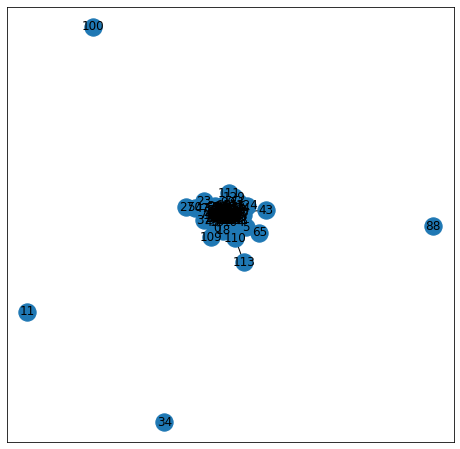

In [176]:
fig = plt.figure(figsize = (8,8))
nx.draw_networkx(graph, with_labels = True, node_size = 300)

In [131]:
nx.write_graphml(graph,"graph2.graphml")

In [177]:
nx.info(graph)

'Name: \nType: Graph\nNumber of nodes: 130\nNumber of edges: 3070\nAverage degree:  47.2308'

In [178]:
ranked_sentences = ((scores[i], s) for i, s in enumerate(sentences))
ranked_sentences = sorted(ranked_sentences, reverse=True)

### Extract top top k sentences as the summary

In [179]:
top_k = 3

for i in range(top_k):
  print(ranked_sentences[i][1])

“I was on a nice trajectorythen,” Reid recalled.“If I hadn’t got sick, I think I could have started pushing towards the second week at the slams and then who knows.” Duringa comeback attempt some five years later, Reid added Bernard Tomic and 2018 US Open Federer slayer John Millman to his list of career scalps.
Exhausted after spending half his round deep in the bushes searching for my ball, as well as those of two other golfers he’d never met before, our incredibly giving designated driver asked if we didn’t mind going straight home after signing off so he could rest up a little before heading to work.
The former Wimbledon junior champion was full of hope, excited about getting his life back together after a troubled few years and a touch-and-go battle with pancreatitis.


### CNN-DM dataset

In [ ]:
cnn_dm = tfds.load("CnnDailymail", split='train', shuffle_files=True)

Shuffling and writing examples to /root/tensorflow_datasets/cnn_dailymail/plain_text/3.0.0.incompleteJU910H/cnn_dailymail-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/cnn_dailymail/plain_text/3.0.0.incompleteJU910H/cnn_dailymail-validation.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/cnn_dailymail/plain_text/3.0.0.incompleteJU910H/cnn_dailymail-test.tfrecord


Dataset cnn_dailymail downloaded and prepared to /root/tensorflow_datasets/cnn_dailymail/plain_text/3.0.0. Subsequent calls will reuse this data.


In [180]:
data_set = cnn_dm.shuffle(1024).batch(10).prefetch(100)
for example in data_set.take(10):
    article = example["article"]
    print(article.numpy()[0].decode()[4:])

French government has in the past repeatedly rejected demands to sell the Mona Lisa (pictured), but a parliamentary report has suggested it sell thousands of pieces of art to pay off national debt . Cash-strapped France could sell thousands of artworks to pay off its vast national debt, a parliamentary report has suggested. The radical plan to flog paintings and sculptures from the nation's prized collections was mooted by MPs studying ways help clear France's £150billion deficit. It comes after state-run news channel France 24 last year even suggested selling the Mona Lisa - the world's most famous painting which hangs in the Louvre museum in Paris. Now lawmakers have consulted Guillaume Cerutti, the head of Sotheby's auctioneers in France, for his opinion on the sale of publicly-owned art. He said France should move closer to a model used in the United States, where museums sometimes sell unseen parts of their collections to free up resources for the purchase of more relevant artwork